# Introduction

# Project description

Sweet Lift Taxi company has collected historical data on taxi orders at airports. To attract more drivers during peak hours, we need to predict the amount of taxi orders for the next hour. Build a model for such a prediction.

The RMSE metric on the test set should not be more than 48.

## Project instructions

1. Download the data and resample it by one hour.
2. Analyze the data.
3. Train different models with different hyperparameters. The test sample should be 10% of the initial dataset. 
4. Test the data using the test sample and provide a conclusion.

## Data description

The data is stored in file `taxi.csv`. The number of orders is in the '*num_orders*' column.

## Preparation

In [53]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler as ss
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from catboost import CatBoostRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
taxi=pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
taxi.sort_index(inplace=True)



In [3]:
taxi.index.is_monotonic

True

In [4]:
print('First Day:', taxi.index.min())
print('Last Day:', taxi.index.max())

First Day: 2018-03-01 00:00:00
Last Day: 2018-08-31 23:50:00


In [5]:
taxi.info()
taxi.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [6]:
taxi.shape

(26496, 1)

In [7]:
taxi.isna().sum()



num_orders    0
dtype: int64

In [8]:
taxi=taxi.reset_index()
taxi

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32
...,...,...
26491,2018-08-31 23:10:00,32
26492,2018-08-31 23:20:00,24
26493,2018-08-31 23:30:00,27
26494,2018-08-31 23:40:00,39


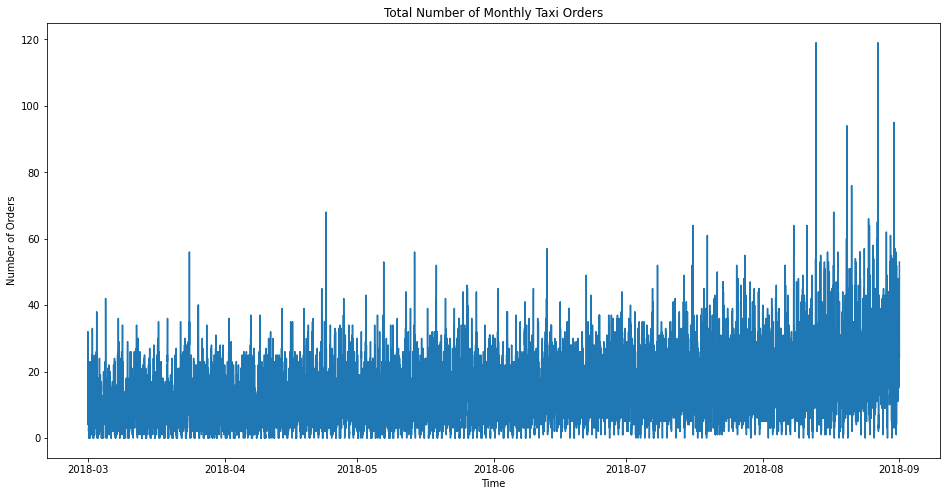

In [9]:
taxi= taxi.groupby(['datetime'])['num_orders'].sum()
plt.figure(figsize=(16,8))
plt.title('Total Number of Monthly Taxi Orders')
plt.xlabel('Time')
plt.ylabel('Number of Orders')
plt.plot(taxi);

In [10]:
taxi=taxi.resample('1H').sum()
taxi


datetime
2018-03-01 00:00:00    124
2018-03-01 01:00:00     85
2018-03-01 02:00:00     71
2018-03-01 03:00:00     66
2018-03-01 04:00:00     43
                      ... 
2018-08-31 19:00:00    136
2018-08-31 20:00:00    154
2018-08-31 21:00:00    159
2018-08-31 22:00:00    223
2018-08-31 23:00:00    205
Freq: H, Name: num_orders, Length: 4416, dtype: int64

* We notice that the highest peaks in taxi orders are observed betweeen the end of August and September.
* A possible explanation for this spike in orders might be because that time period is associated with the start of school/college/internships and most people may be traveling home from vacations or temporary stays.

## Analysis

In [11]:
from statsmodels.tsa.seasonal import seasonal_decompose

Text(0.5, 1.0, 'Trend')

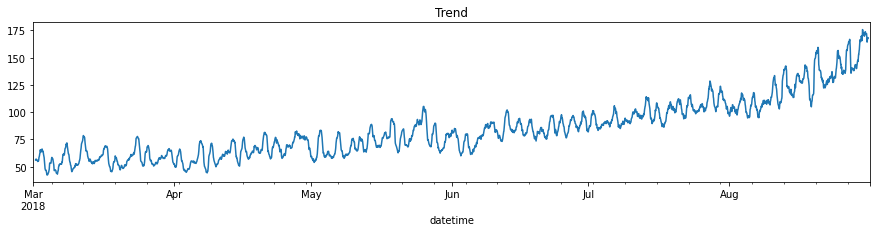

In [12]:
decomposed = seasonal_decompose(taxi, 'additive')

plt.figure(figsize=(6, 8))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca(), figsize=(15, 10))
plt.title('Trend')

We observe that the overall trend in the number of orders tends to increase over time.

Text(0.5, 1.0, 'Seasonality')

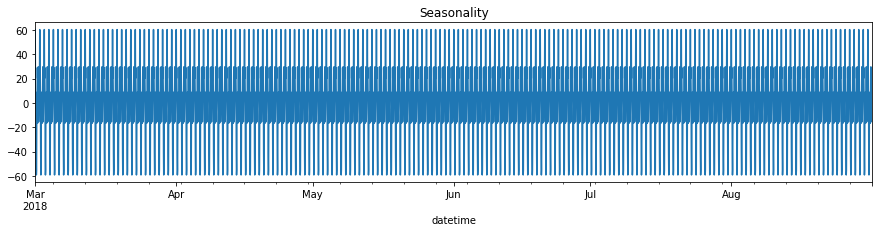

In [13]:
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca(), figsize=(15, 10))
plt.title('Seasonality')


Text(0.5, 1.0, 'Seasonality line for first week\n')

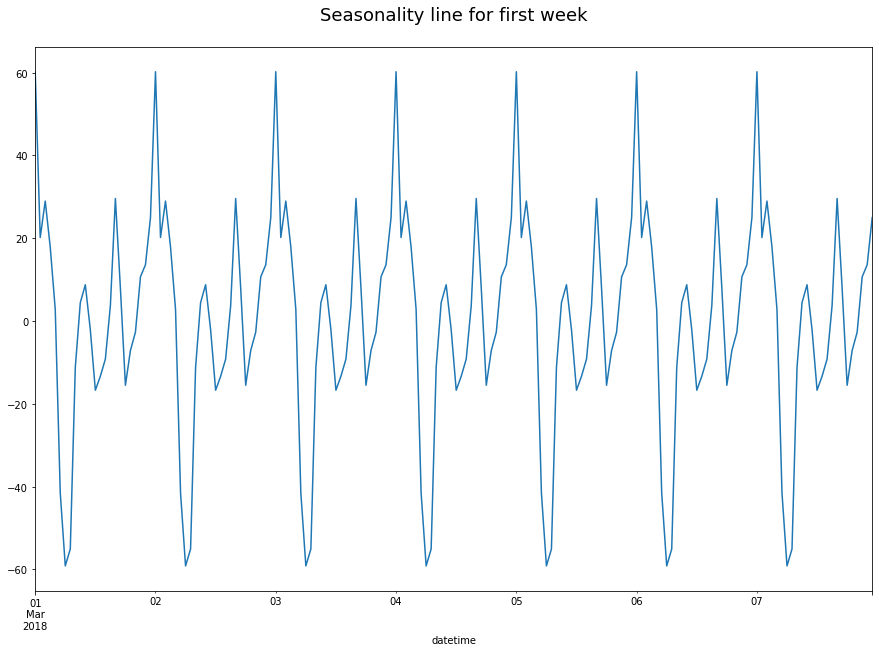

In [14]:
first_week=decomposed.seasonal['2018-03-01':'2018-03-07'].plot(ax=plt.gca(), figsize=(15, 10))
plt.title('Seasonality line for first week\n', fontsize=18)

Text(0.5, 1.0, 'Seasonality line for last week\n')

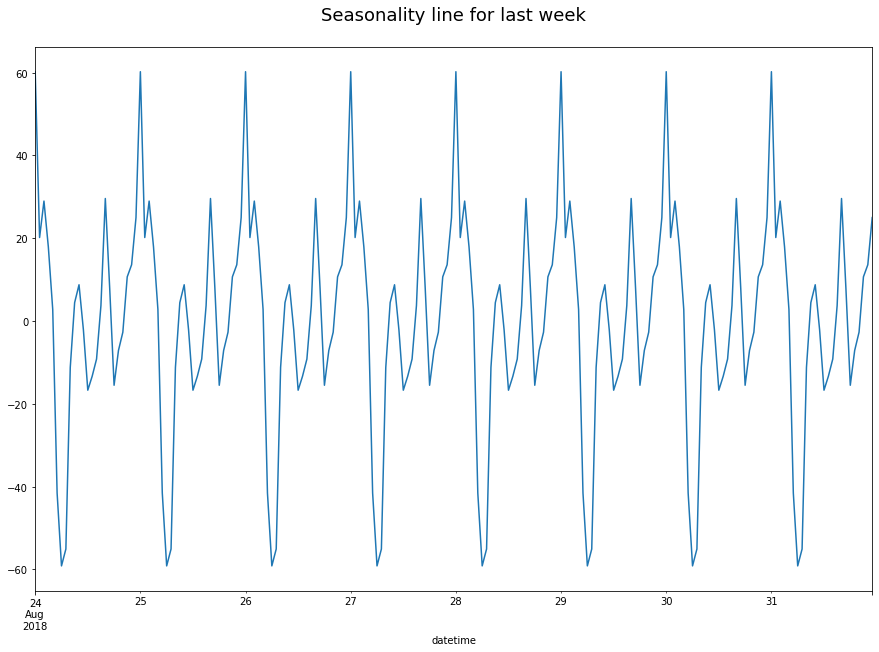

In [56]:
last_week=decomposed.seasonal['2018-08-24':'2018-08-31'].plot(ax=plt.gca(), figsize=(15, 10))
plt.title('Seasonality line for last week\n', fontsize=18)

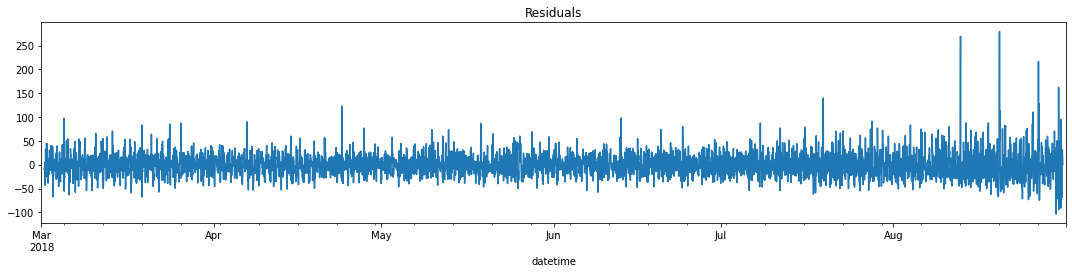

In [16]:
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca(), figsize=(15, 10))
plt.title('Residuals')
plt.tight_layout()

In [17]:
def plotMovingAverage(series, window, plot_intervals=False, scale=1.96, plot_anomalies=False):

    """
        series - dataframe with timeseries
        window - rolling window size 
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 

    """
    rolling_mean = series.rolling(window=window).mean()

    plt.figure(figsize=(15,5))
    plt.title("Moving average\n window size = {}".format(window))
    plt.plot(rolling_mean, "g", label="Rolling mean trend")

    # Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bond = rolling_mean - (mae + scale * deviation)
        upper_bond = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
        plt.plot(lower_bond, "r--")
        
        # Having the intervals, find abnormal values
        if plot_anomalies:
            anomalies = pd.DataFrame(index=series.index, columns=series.columns)
            anomalies[series<lower_bond] = series[series<lower_bond]
            anomalies[series>upper_bond] = series[series>upper_bond]
            plt.plot(anomalies, "ro", markersize=10)
        
    plt.plot(series[window:], label="Actual values", alpha=0.5)
    plt.legend(loc="upper left")
    plt.grid(True)

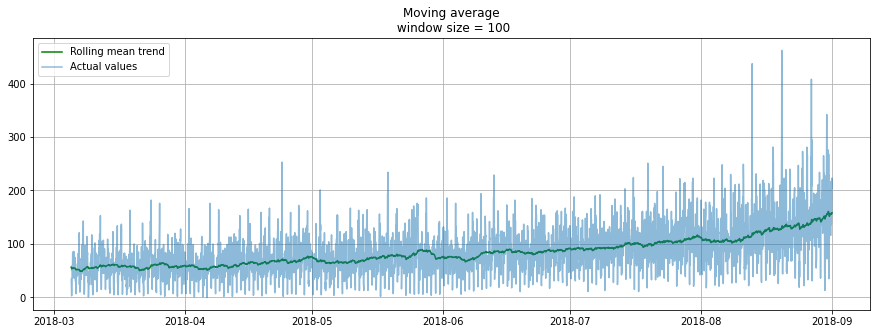

In [18]:
plotMovingAverage(taxi, 100)

* We observe that the while the average taxi orders hovers around about 10 from March to June, we see a steady increase which reaches nearly 30 taxis per hour in September.

## Training

In [19]:
taxi

datetime
2018-03-01 00:00:00    124
2018-03-01 01:00:00     85
2018-03-01 02:00:00     71
2018-03-01 03:00:00     66
2018-03-01 04:00:00     43
                      ... 
2018-08-31 19:00:00    136
2018-08-31 20:00:00    154
2018-08-31 21:00:00    159
2018-08-31 22:00:00    223
2018-08-31 23:00:00    205
Freq: H, Name: num_orders, Length: 4416, dtype: int64

In [20]:
taxi=pd.DataFrame(taxi)
taxi

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


In [21]:
def make_features(data, max_lag, rolling_mean_size):
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hourofday'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    data['rolling_std'] = data['num_orders'].shift().rolling(rolling_mean_size).std()
    
make_features(taxi, 10, 5)



In [57]:
taxi.head()

,taxi_cnt_hour,month,day,dayofweek,hourofday,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,rolling_mean,rolling_std
datetime,,,,,,,,,,,,,,,,,
2018-03-01 10:00:00,64,3,1,3,10,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,124.0,27.2,25.606640
2018-03-01 11:00:00,96,3,1,3,11,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,38.8,26.715164
2018-03-01 12:00:00,30,3,1,3,12,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,55.6,31.611707
2018-03-01 13:00:00,32,3,1,3,13,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,58.6,27.199265
2018-03-01 14:00:00,48,3,1,3,14,32.0,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,58.2,27.662249


In [23]:
taxi.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 17 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   num_orders    4416 non-null   int64  
 1   month         4416 non-null   int64  
 2   day           4416 non-null   int64  
 3   dayofweek     4416 non-null   int64  
 4   hourofday     4416 non-null   int64  
 5   lag_1         4415 non-null   float64
 6   lag_2         4414 non-null   float64
 7   lag_3         4413 non-null   float64
 8   lag_4         4412 non-null   float64
 9   lag_5         4411 non-null   float64
 10  lag_6         4410 non-null   float64
 11  lag_7         4409 non-null   float64
 12  lag_8         4408 non-null   float64
 13  lag_9         4407 non-null   float64
 14  lag_10        4406 non-null   float64
 15  rolling_mean  4411 non-null   float64
 16  rolling_std   4411 non-null   float64
dtypes: float64(12), int64(5)
me

In [58]:
taxi=taxi.dropna()
taxi.head()

,taxi_cnt_hour,month,day,dayofweek,hourofday,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,rolling_mean,rolling_std
datetime,,,,,,,,,,,,,,,,,
2018-03-01 10:00:00,64,3,1,3,10,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,124.0,27.2,25.606640
2018-03-01 11:00:00,96,3,1,3,11,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,38.8,26.715164
2018-03-01 12:00:00,30,3,1,3,12,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,55.6,31.611707
2018-03-01 13:00:00,32,3,1,3,13,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,58.6,27.199265
2018-03-01 14:00:00,48,3,1,3,14,32.0,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,58.2,27.662249


In [25]:
taxi.isna().sum()

num_orders      0
month           0
day             0
dayofweek       0
hourofday       0
lag_1           0
lag_2           0
lag_3           0
lag_4           0
lag_5           0
lag_6           0
lag_7           0
lag_8           0
lag_9           0
lag_10          0
rolling_mean    0
rolling_std     0
dtype: int64

In [26]:
taxi=taxi.rename(columns={'num_orders':'taxi_cnt_hour'})
taxi=taxi.sort_index()
taxi

,taxi_cnt_hour,month,day,dayofweek,hourofday,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,rolling_mean,rolling_std
datetime,,,,,,,,,,,,,,,,,
2018-03-01 10:00:00,64,3,1,3,10,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,124.0,27.2,25.606640
2018-03-01 11:00:00,96,3,1,3,11,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,38.8,26.715164
2018-03-01 12:00:00,30,3,1,3,12,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,55.6,31.611707
2018-03-01 13:00:00,32,3,1,3,13,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,58.6,27.199265
2018-03-01 14:00:00,48,3,1,3,14,32.0,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,58.2,27.662249
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136,8,31,4,19,207.0,217.0,197.0,116.0,133.0,166.0,136.0,167.0,191.0,203.0,174.0,46.130250
2018-08-31 20:00:00,154,8,31,4,20,136.0,207.0,217.0,197.0,116.0,133.0,166.0,136.0,167.0,191.0,174.6,45.478566
2018-08-31 21:00:00,159,8,31,4,21,154.0,136.0,207.0,217.0,197.0,116.0,133.0,166.0,136.0,167.0,182.2,35.266131


# Split Data into Training and Test sets

In [27]:
features = taxi.drop('taxi_cnt_hour', axis=1)
target = taxi['taxi_cnt_hour']

In [28]:
features_train, features_test, target_train, target_test = train_test_split(features, target, shuffle=False, test_size=0.1)

In [32]:
def rmse(true, pred):
    return mean_squared_error(true, pred)**0.5

In [33]:
features_train

,month,day,dayofweek,hourofday,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,rolling_mean,rolling_std
datetime,,,,,,,,,,,,,,,,
2018-03-01 10:00:00,3,1,3,10,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,124.0,27.2,25.606640
2018-03-01 11:00:00,3,1,3,11,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,38.8,26.715164
2018-03-01 12:00:00,3,1,3,12,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,55.6,31.611707
2018-03-01 13:00:00,3,1,3,13,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,58.6,27.199265
2018-03-01 14:00:00,3,1,3,14,32.0,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,58.2,27.662249
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-13 10:00:00,8,13,0,10,137.0,91.0,39.0,66.0,83.0,143.0,168.0,437.0,273.0,160.0,83.2,36.072150
2018-08-13 11:00:00,8,13,0,11,156.0,137.0,91.0,39.0,66.0,83.0,143.0,168.0,437.0,273.0,97.8,48.576743
2018-08-13 12:00:00,8,13,0,12,144.0,156.0,137.0,91.0,39.0,66.0,83.0,143.0,168.0,437.0,113.4,48.335287


# Scale the data and use RMSE metric to select best model

In [34]:
sc = ss()
features_train = sc.fit_transform(features_train)
features_test = sc.transform(features_test)

In [35]:
tscv = TimeSeriesSplit()

In [36]:
def rmse(actual, predict):
    predict = np.array(predict)
    actual = np.array(actual)

    distance = predict - actual
    square_distance = distance ** 2
    mean_square_distance = square_distance.mean()
    score = np.sqrt(mean_square_distance)
    return score

rmse_scorer = make_scorer(rmse, greater_is_better = False)

In [37]:
model = DummyRegressor(strategy='median')
baseline = np.mean(abs(cross_val_score(model,  features_train, target_train, cv=tscv, scoring = rmse_scorer)))
baseline

41.598174732872344

* The Data is scaled 
* TimeSeriesSplit is utilized for cross validation
* We are utilizing rmese scorer to compare model metrics

In [38]:
lr = LinearRegression()
lr_mod= np.mean(abs(cross_val_score(lr,  features_train, target_train, cv=tscv, scoring = rmse_scorer)))
print('Linear Regression RMSE Train:', lr_mod)


Linear Regression RMSE Train: 7514936117.212375


In [39]:
dt=DecisionTreeRegressor(random_state=12345)
dt_mod= np.mean(abs(cross_val_score(dt,  features_train, target_train, cv=tscv, scoring = rmse_scorer)))
print('Decision Tree Regresor_1:', dt_mod)


Decision Tree Regresor_1: 34.383366933560936


In [40]:
%%time
params = {"max_depth" : [6, 7, 8, 9, 10]}

gsSVR = GridSearchCV(estimator=dt, cv=tscv, param_grid=params, n_jobs=-1, verbose=0, scoring=rmse_scorer)
gsSVR.fit(features_train, target_train)
SVR_best = gsSVR.best_estimator_
print(abs(gsSVR.best_score_))

30.589740958196046
CPU times: user 367 ms, sys: 8.16 ms, total: 375 ms
Wall time: 380 ms


In [41]:
%%time
best_param = pd.DataFrame(gsSVR.best_params_, index=[0])
dt_tuned = abs(gsSVR.best_score_)
best_param['score'] = dt_tuned

best_param

CPU times: user 2.03 ms, sys: 26 µs, total: 2.06 ms
Wall time: 1.76 ms


,max_depth,score
0,8,30.589741


In [42]:
rf = RandomForestRegressor(random_state=12345)
rf_mod= np.mean(abs(cross_val_score(rf,  features_train, target_train, cv=tscv, scoring = rmse_scorer)))
print('RandomForestRegressor_1:', rf_mod)


RandomForestRegressor_1: 25.400545878732284


In [43]:
%%time
params = {"n_estimators": [15, 30, 50], "max_depth" : [6, 7, 8, 9, 10]}

gsSVR = GridSearchCV(estimator=rf, cv=tscv, param_grid=params, n_jobs=-1, verbose=0, scoring=rmse_scorer)
gsSVR.fit(features_train, target_train)
SVR_best = gsSVR.best_estimator_
print(abs(gsSVR.best_score_))

25.871291409088037
CPU times: user 21.7 s, sys: 73.9 ms, total: 21.7 s
Wall time: 21.8 s


In [44]:
%%time
best_param = pd.DataFrame(gsSVR.best_params_, index=[0])
rf_tuned = abs(gsSVR.best_score_)
best_param['score'] = rf_tuned

best_param

CPU times: user 1.76 ms, sys: 70 µs, total: 1.83 ms
Wall time: 1.48 ms


,max_depth,n_estimators,score
0,10,50,25.871291


In [45]:
%%time
lgbm = LGBMRegressor(random_state=12345)
lgbm_original = np.mean(abs(cross_val_score(lgbm,  features_train, target_train, cv=tscv, scoring = rmse_scorer)))
lgbm_original

CPU times: user 3.93 s, sys: 79.3 ms, total: 4.01 s
Wall time: 4.02 s


25.15885424306553

In [46]:
%%time
params = {"n_estimators" : [15, 30, 60], "max_depth" : [6, 7, 8, 9, 10]}

gsSVR = GridSearchCV(estimator=lgbm, cv=tscv, param_grid=params, n_jobs=-1, verbose=0, scoring=rmse_scorer)
gsSVR.fit(features_train, target_train)
SVR_best = gsSVR.best_estimator_
print(abs(gsSVR.best_score_))

24.983366900591683
CPU times: user 31.2 s, sys: 135 ms, total: 31.4 s
Wall time: 31.6 s


In [47]:
%%time
best_param = pd.DataFrame(gsSVR.best_params_, index=[0])
lgbm_tuned = abs(gsSVR.best_score_)
best_param['score'] = lgbm_tuned

best_param

CPU times: user 1.64 ms, sys: 37 µs, total: 1.68 ms
Wall time: 1.39 ms


,max_depth,n_estimators,score
0,8,60,24.983367


* While the RandomForest Regressor model with tuned parameters performs well, the LGBM generates a slightly better RMSE metric. * Thus, we will select the LGBM and use the test set to evaluate this model.

## Testing

In [64]:
lgbm.fit(features_train, target_train)
test_pred=lgbm.predict(features_test)
lgbm_test_score=rmse(target_test, test_pred)
lgbm_test_score

43.06196823251162

# Conclusion

The objective of this project was to build a model to effectively predict the number of hourly taxi orders. The best model with the lowest RMSE scores resulted in untuned LGBM model, thus is was selected for testing. The RMSE metric on the test set resulted in a value of 43.06, which is below the desired threshold of 48. It differs from the RMSE metric from the validation set, but indicates that the model has still has decent predictive power. Based on the results, I would reccomned this model be utilized. 

<div class="alert alert-danger">
<s><b>Reviewer's comment V2</b>

Probably adding an hour feature would help a lot, as we're doing hourly predictions :)
    
Also you're using very complex models (500 trees?), so they are probably overfitted

</div>

<div class="alert alert-info">
Thanks so much for the advice! Adding the hour feature really did the trick! Also reducing the range in n_estimators also definetly helped achieve the desired result. Thank you for all your help and advice! 
</div>

<div class="alert alert-success">
<b>Reviewer's comment V3</b>

No problem! Glad my comments were helpful :)

</div>

# Review checklist

- [x]  Jupyter Notebook is open
- [ ]  The code is error-free
- [ ]  The cells with the code have been arranged in order of execution
- [ ]  The data has been downloaded and prepared
- [ ]  The data has been analyzed
- [ ]  The model has been trained and hyperparameters have been selected
- [ ]  The models have been evaluated. Conclusion has been provided
- [ ] *RMSE* for the test set is not more than 48